In [24]:
import math

import ConnectionNetworkX as cnx
import numpy as np
import networkx as nx
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm


# Solving the Beckmann problem on a grid graph, i.e., pixel space.

Initialize the grid graph

In [25]:

GRID_WIDTH = 32
GRID_HEIGHT = 32
INTRINSIC_DIM = 3

gridGraph = cnx.cnxFromPixelGrid(GRID_WIDTH, GRID_HEIGHT, INTRINSIC_DIM)

gridGraphIncidenceMatrix = gridGraph.connectionIncidenceMatrix


Generate the constraint matrices and densities to be transported. Example seen here is dirac densities at corners of the grid.

In [26]:
import imageio

def localizedColorDensity(grid, centerInEmbeddingSpace, normalizedRGBValues, radiusInCanonicalEmbeddingSpace):

    RGB_DIM = 3

    x0, y0 = centerInEmbeddingSpace

    density = np.zeros((gridGraph.nNodes, RGB_DIM))#.flatten()[:,None]

    # In order for it to be a valid density we need to add some ambient color so the row sum is positive everywhere
    uniformNoise = (1 - normalizedRGBValues) / grid.nNodes

    for node in tqdm(grid.nodes):

        x, y = grid.gridEmbedding[node]

        d = ((x - x0) ** 2 + (y - y0) ** 2) ** 0.5

        if d <= radiusInCanonicalEmbeddingSpace:
            #alpha = math.exp(- math.log(4) * d / radiusInCanonicalEmbeddingSpace)
            alpha = 1 - d / radiusInCanonicalEmbeddingSpace
            scaledRGB = (alpha) * normalizedRGBValues
        else:
            scaledRGB = np.array([0, 0, 0])

        density[node, :] = scaledRGB + uniformNoise

    s = np.sum(density, axis=0)
    for dim in range(RGB_DIM):
        density[:, dim] /= s[dim]

    density = density.flatten()

    return density

def colorDensityFromImage(grid, path, RGB_DIM = 3):

    image = imageio.v3.imread(path) / 255
    density = np.zeros((gridGraph.nNodes, RGB_DIM))

    print("Processing image density ... ")

    for node in tqdm(grid.nodes):

        x, y = grid.gridEmbedding[node]
        j, i = min(math.floor(image.shape[0] * (x)), image.shape[0]-1), min(math.floor(image.shape[1] * (1-y)), image.shape[1] - 1)

        density[node, :] = np.array(image[i, j])

    s = np.sum(density, axis=0)
    for dim in range(RGB_DIM):
        density[:, dim] /= s[dim]

    density = density.flatten()

    return density

def renderColorDensityAsImage(grid, localizedColorDensity):

    fig, ax = plt.subplots()
    embedding = grid.gridEmbedding
    RGB_DIM = 3

    invertedCD = 1 - localizedColorDensity

    ax.set_xlim((0, 1 + 1/GRID_WIDTH))
    ax.set_ylim((0, 1 + 1/GRID_HEIGHT))

    for node in tqdm(list(range(gridGraph.nNodes))):

        INTENSITY = 1 / np.max(localizedColorDensity)

        center = embedding[node][0], embedding[node][1]
        colorRGB = (INTENSITY*( localizedColorDensity[(node * RGB_DIM) : ((node + 1) * RGB_DIM)])).tolist() + [1]

        nodeLabel = matplotlib.patches.Rectangle(center, 1/GRID_WIDTH, 1/GRID_HEIGHT, color=colorRGB)
        ax.add_patch(nodeLabel)

    plt.show()

Processing image density ... 


100%|██████████| 1024/1024 [00:00<00:00, 78448.32it/s]


Processing image density ... 


100%|██████████| 1024/1024 [00:04<00:00, 243.68it/s]


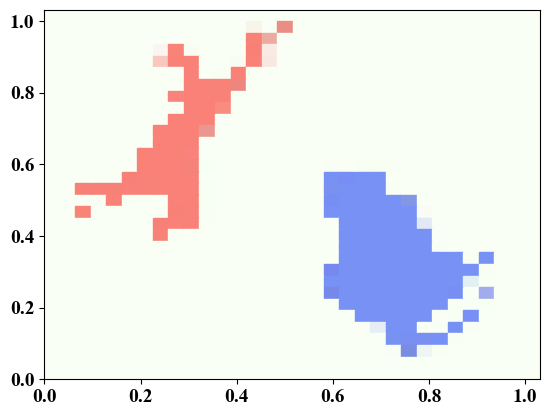

In [28]:

cat = colorDensityFromImage(gridGraph, 'data/red_horse_2.jpg')
horse = colorDensityFromImage(gridGraph, 'data/blue_cat_2.jpg')

renderColorDensityAsImage(gridGraph, cat + horse)


In [29]:
import torch
import time

t0 = time.time()

c = cat - horse
c.reshape((gridGraph.nNodes, INTRINSIC_DIM))
c = torch.tensor(c)

t1 = time.time()
print("time to init c: ", t1 - t0)

B = torch.tensor(gridGraphIncidenceMatrix.toarray())
w = torch.tensor(np.array([edge[2]['weight'] for edge in gridGraph.edges(data=True)]).astype('float32'))

t2 = time.time()
print("time to init B, w: ", t2 - t1)

#initialPhi = -np.matmul(np.linalg.pinv(np.matmul(B, B.T)), c)
initialPhi = -np.matmul(sp.linalg.pinvh(np.matmul(B, B.T)), c)

t3 = time.time()
print("time to init initPhi: ", t3-t2)

time to init c:  0.0020110607147216797
time to init B, w:  0.33910059928894043
time to init initPhi:  17.37202215194702


In [30]:
learning_rate = 1e-2
alpha = 1
n_epochs = 10000

gridPhi = cnx.optimize(B.T, w, c, alpha, learning_rate, n_epochs, phi0=initialPhi)

epoch: 0, loss: 0.001642, loss0: 0.001642, loss1: 0.000000


C:\Users\Sawyer\Documents\IdeaProjects\connection-graph-wasserstein\ConnectionNetworkX.py:224: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(phi0, requires_grad=True)


epoch: 10, loss: -0.046117, loss0: -0.046117, loss1: 0.000000
epoch: 20, loss: -0.093877, loss0: -0.093877, loss1: 0.000000
epoch: 30, loss: -0.141637, loss0: -0.141637, loss1: 0.000000
epoch: 40, loss: -0.185484, loss0: -0.185484, loss1: 0.000000
epoch: 50, loss: -0.225623, loss0: -0.225623, loss1: 0.000000
epoch: 60, loss: -0.259240, loss0: -0.259240, loss1: 0.000000
epoch: 70, loss: -0.293966, loss0: -0.294066, loss1: 0.000200
epoch: 80, loss: -0.329162, loss0: -0.329218, loss1: 0.000111
epoch: 90, loss: -0.363908, loss0: -0.364037, loss1: 0.000259
epoch: 100, loss: -0.398153, loss0: -0.398648, loss1: 0.000992
epoch: 110, loss: -0.432208, loss0: -0.432354, loss1: 0.000293
epoch: 120, loss: -0.465064, loss0: -0.465546, loss1: 0.000964
epoch: 130, loss: -0.497586, loss0: -0.497777, loss1: 0.000382
epoch: 140, loss: -0.529117, loss0: -0.529185, loss1: 0.000136
epoch: 150, loss: -0.560196, loss0: -0.560347, loss1: 0.000303
epoch: 160, loss: -0.590450, loss0: -0.590758, loss1: 0.000616
e

# Visualizing the Soln. to the Connection Beckmann Problem on a Grid

In [31]:
regularizedActiveEdges = cnx.active_edges(gridPhi, B.T, w, c).detach().numpy()
#regularizedEdgeFlows = torch.matmul(B.T, gridPhi).detach().numpy()
regularizedEdgeFlows =  cnx.optimal_J(gridPhi, B.T, w, alpha, INTRINSIC_DIM).detach().numpy()
regularizedEdgeFlows = regularizedEdgeFlows.flatten()

#mask = (regularizedActiveEdges > 0)
#regularizedEdgeFlows[mask, :] /= regularizedActiveEdges[mask][:, np.newaxis]/alpha
#regularizedEdgeFlows = ((1 + regularizedEdgeFlows )/ 2).flatten()


In [32]:
J = cnx.optimal_J(gridPhi, B.T, w, alpha, INTRINSIC_DIM)

np.linalg.norm(torch.matmul(B, J.flatten()).detach().numpy() - c.detach().numpy())


0.1325669475964625

100%|██████████| 1024/1024 [00:01<00:00, 718.47it/s]


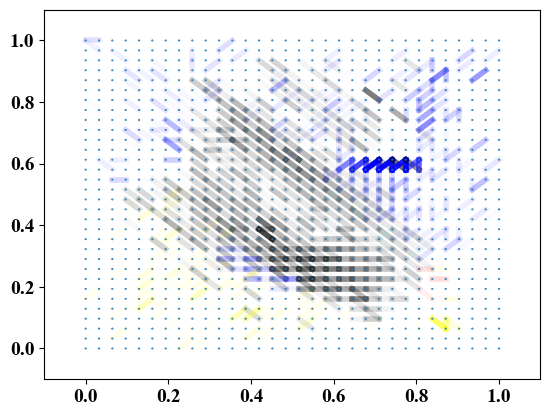

In [33]:
spectralEmbedding = gridGraph.gridEmbedding

TOLERANCE = 0
MAX = np.max(regularizedActiveEdges)

fig, ax = plt.subplots()
ax.set_xlim((-.1, 1.1))
ax.set_ylim((-.1, 1.1))

for node in tqdm(list(range(gridGraph.nNodes))):
    center = spectralEmbedding[node][0], spectralEmbedding[node][1]
    col = "tab:blue" # phi[(node * INTRINSIC_DIM) : ((node + 1) * INTRINSIC_DIM) ].tolist() + [1]  #"tab:blue"
    zNode=4
    r=1e-3
    nodeLabel = matplotlib.patches.Circle(center, radius=r, color=col, zorder=zNode)
    ax.add_patch(nodeLabel)

for edgeIndex, edge in zip(range(gridGraph.nEdges), list(gridGraph.edges())):

    flow = (regularizedEdgeFlows[(edgeIndex * INTRINSIC_DIM) : ((edgeIndex + 1) * INTRINSIC_DIM) ]).tolist()

    #col = gridPhi[(edge[0] * INTRINSIC_DIM) : ((edge[0] + 1) * INTRINSIC_DIM) ]

    flow =  [ x % 1.0 for x in flow] #  #1 + x  #

    if regularizedActiveEdges[edgeIndex] > TOLERANCE:

        alpha = abs(regularizedActiveEdges[edgeIndex])/MAX
        col= flow  + [alpha] #(1, 0, 0, alpha) #flow + [alpha] #(1, 0, .1, abs(regularizedActiveEdges[edgeIndex])/MAX)
        z = 3
        lw = 4

    else:
        #col="tab:blue"
        lw=0.5
        col=(1,1,1,0)
        z = 3

    fromNode = edge[0]
    toNode = edge[1]
    centerFromNode = spectralEmbedding[fromNode][0], spectralEmbedding[fromNode][1]
    centerToNode = spectralEmbedding[toNode][0], spectralEmbedding[toNode][1]

    ax.plot((centerFromNode[0], centerToNode[0]), (centerFromNode[1], centerToNode[1]), color=col, lw=lw)

plt.show()

# xData, yData = spectralEmbedding.values

In [ ]:
plt.hist(regularizedEdgeFlows)